In [82]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import tiktoken

batch_size = 128
max_len = 256
d_model = 512
n_layers = 6
n_heads = 8
ffn_hidden = 2048
drop_prob = 0.1
init_lr = 0.1
factor = 0.9
patience = 10
warmup = 100
adam_eps = 5e-9
epoch = 1000
clip = 1
weight_decay = 5e-4

In [83]:
l = os.listdir("harry")
data = ""
for i in l:
    with open("harry/"+i, 'r') as f:
        data += f.read()
data[:1000]

'M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.\n\nMr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.\n\nThe Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley’s sister, but they hadn’t met for sever

In [84]:
chars = list(set(data))
vocab_size_char = len(chars)
print(f"Vocab size: {vocab_size_char}")

enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")
vocab_size = enc.n_vocab
print(f"Vocab size: {vocab_size}")

Vocab size: 106
Vocab size: 200019


In [85]:
encoded_data = enc.encode(data)

In [86]:
train = torch.tensor(encoded_data[:int(len(encoded_data)*0.9)], dtype=torch.long)
val = torch.tensor(encoded_data[int(len(encoded_data)*0.9):], dtype=torch.long)

# source = source.view(-1, max_len)
# target = target.view(-1, max_len)

train.shape, val.shape

(torch.Size([1326075]), torch.Size([147342]))

In [87]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train
    ix = torch.randint(len(data) - max_len, (batch_size,))
    x = torch.stack([data[i:i+max_len] for i in ix])
    y = torch.stack([data[i+1:i+max_len+1] for i in ix])
    # x, y = x.to(device), y.to(device)
    return x, y

x_t, y_t = get_batch("train")
x_t.shape, y_t.shape

(torch.Size([128, 256]), torch.Size([128, 256]))

In [88]:
# class Embedding(nn.Module):
#     def __init__(self, vocab_size, d_model=d_model):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.d_model = d_model
#         self.embedding = nn.Embedding(self.vocab_size, self.d_model)
#     def forward(self, x):
#         embed = self.embedding(x)
#         return embed * np.sqrt(self.d_model)
import math

class Embedding(nn.Module):
    def __init__(self,vocab_size,dmodel=512) -> None:
        super(Embedding,self).__init__()
        self.vocab_size = vocab_size
        # dmodel -> embedding model dimention
        self.dmodel = dmodel
        self.embed_layer = nn.Embedding(self.vocab_size,self.dmodel)
    def forward(self,x):
        embed_out = self.embed_layer(x)
        # As auther mention -> In the embedding layers, we multiply those weights by sqrt(dmodel)  -> page 5
        return embed_out * math.sqrt(self.dmodel)

In [89]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, max_len, d_model=d_model):
#         super().__init__()
#         self.d_model = d_model
#         self.max_len = max_len
#         even_i = torch.arange(0, self.d_model, 2).float()
#         # odd_i = torch.arange(1, self.d_model, 2).float()
#         denominator = torch.pow(10000, even_i / self.d_model)
#         pos = torch.arange(self.max_len).reshape(self.max_len, 1).float()
#         even_PE = torch.sin(pos / denominator)
#         odd_PE = torch.cos(pos / denominator) 
#         stack = torch.stack([even_PE, odd_PE], dim=2)
#         PE = torch.flatten(stack, start_dim=1, end_dim=2)
#         self.PE = PE

#     def forward(self , embed):
#         return self.PE + embed
#         # return PE

class PositionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model=512) -> None:
        super(PositionalEncoding,self).__init__()
        self.d_model = d_model
        pos = torch.arange(0, max_seq_len,dtype = torch.float).unsqueeze(1)
        # we know a^-x  is equals to 1/a^x
        frequency = torch.pow(10000,-torch.arange(0,d_model,2,dtype = torch.float)/self.d_model)
        pe = torch.zeros((max_seq_len,d_model))
        pe[:,0::2] = torch.sin(pos * frequency)
        pe[:,1::2] = torch.cos(pos * frequency)
        # Here we use register_buffer, because it avoid update model parameter during backpropagation
        self.register_buffer('pe', pe)
    def forward(self,embed_vect):
        # add embedding output and positional encoding
        return embed_vect + self.pe

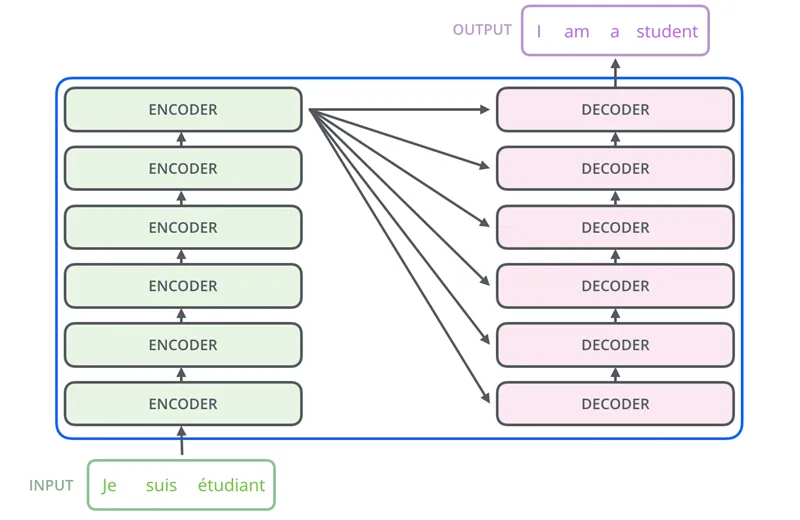

In [104]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=d_model, n_heads=n_heads, dropout_rate = 0.2):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_model // self.n_heads
        self.W_Q = nn.Linear(self.d_model, self.d_model)
        self.W_K = nn.Linear(self.d_model, self.d_model)
        self.W_V = nn.Linear(self.d_model, self.d_model)
        self.W_O = nn.Linear(self.d_model, self.d_model)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout_rate)
        self.tril = torch.tril(torch.ones(2048, 2048))

    def attention(self, Q, K, V):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        batch_size, n_heads, seq_len, _ = scores.size()
        
        mask = self.tril[:seq_len, :seq_len].unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        # scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        attention = self.softmax(scores)
        attention = self.dropout(attention)
        output = torch.matmul(attention, V) 
        return output
    
    def forward(self, Q, K, V):
        Q, K, V = self.W_Q(Q), self.W_K(K), self.W_V(V)
        
        Q = Q.view(Q.shape[0], -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(K.shape[0], -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(V.shape[0], -1, self.n_heads, self.d_k).transpose(1, 2)

        attention = self.attention(Q, K, V)
        attention = attention.transpose(1, 2).contiguous().view(Q.shape[0], -1, self.d_model)
        return self.W_O(attention)
    

In [91]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, d_model=d_model, dropout_rate=0.2):
        super().__init__()
        self.d_model = d_model
        hidden_width = 4
        self.linear1 = nn.Linear(self.d_model, d_model*hidden_width)
        self.linear2 = nn.Linear(d_model*hidden_width, self.d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [112]:
class SubLayer(nn.Module):
    def __init__(self, d_model=d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, sublayer):
        out = self.norm(x + sublayer)
        return out

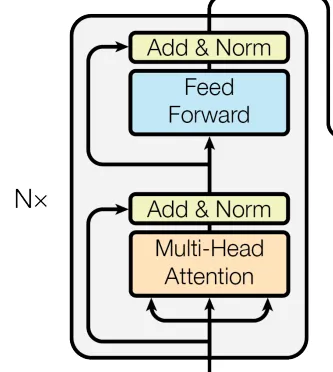

In [93]:
class EncoderLayer(nn.Module):
    def __init__(self,d_model=d_model, dropout_rate = 0.2) -> None:
        super().__init__()
        self.d_model = d_model
        self.multi_head_attention = MultiHeadAttention(self.d_model)
        self.position_wise_feedforward = PointWiseFeedForward(self.d_model)
        self.drop1 = nn.Dropout(dropout_rate)
        self.drop2 = nn.Dropout(dropout_rate)
        self.sublayer1 = SubLayer(self.d_model)
        self.sublayer2 = SubLayer(self.d_model)
    
    def forward(self, vec_rep):
        attention = self.multi_head_attention(vec_rep, vec_rep, vec_rep)
        attention = self.drop1(vec_rep)
        attention = self.sublayer1(vec_rep, attention)
        
        out = self.position_wise_feedforward(attention)
        out = self.drop2(out)
        out = self.sublayer2(attention, out)
        return vec_rep
        

In [94]:
class Encoder(nn.Module):
    def __init__(self, num_layer = 6) -> None:
        super().__init__()
        self.encoder_layer = EncoderLayer()
        self.layers = nn.ModuleList([self.encoder_layer for _ in range(num_layer)])
        
    def forward(self, vec_rep):
        src_vec = vec_rep
        for layer in self.layers:
            src_vec = layer(src_vec)
        return src_vec

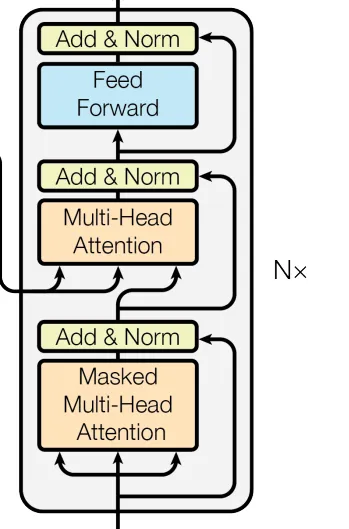

In [95]:
import copy

class DecoderLayer(nn.Module):
    def __init__(self, d_model=d_model, dropout_rate=0.2):
        super().__init__()
        self.d_model = d_model
        self.decoder_attention_layer = MultiHeadAttention()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.sublayer1 = SubLayer(d_model)

        self.encoder_decoder_attention_layer = MultiHeadAttention()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.sublayer2 = SubLayer(d_model)

        self.position_wise_feedforward_layer = PointWiseFeedForward()
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.sublayer3 = SubLayer(d_model)
    
    def forward(self, tgt_vec, src_vec):
        tgt_attention = self.decoder_attention_layer(tgt_vec, tgt_vec, tgt_vec)
        tgt_attention = self.dropout1(tgt_attention)
        tgt_attention = self.sublayer1(tgt_vec, tgt_attention)

        encoder_decoder_attention = self.encoder_decoder_attention_layer(tgt_attention, src_vec, src_vec)
        encoder_decoder_attention = self.dropout2(encoder_decoder_attention)
        encoder_decoder_attention = self.sublayer2(tgt_vec, encoder_decoder_attention)

        out = self.position_wise_feedforward_layer(encoder_decoder_attention)
        out = self.dropout3(out)
        out = self.sublayer3(encoder_decoder_attention, out)
        return out

In [96]:
class Decoder(nn.Module):
    def __init__(self, num_layer=6):
        super().__init__()
        self.decoder_layer = DecoderLayer()
        self.layers = nn.ModuleList([self.decoder_layer for _ in range(num_layer)])
    
    def forward(self, tgt_vec, src_vec):
        dec_out = src_vec
        for layer in self.layers:
            tgt_vec = layer(tgt_vec, dec_out)
        return tgt_vec

In [97]:
class DecoderGenerator(nn.Module):
    def __init__(self,d_model,target_vocab_size) -> None:
        super().__init__()
        self.linear = nn.Linear(d_model,target_vocab_size)
        self.softmax_layer = nn.LogSoftmax(dim=-1)
    def forward(self,target_vec_rep):
        return self.softmax_layer(self.linear(target_vec_rep))

In [102]:
class Transformers(nn.Module):
    def __init__(self,vocab_size,d_model,num_head,dropout_rate = 0.2) -> None:
        super().__init__()
        # self.src_seq_len = src_seq_len
        # self.trg_seq_len = trg_seq_len
        self.d_model = d_model
        self.num_head = num_head

        self.src_embedding = Embedding(vocab_size,self.d_model)
        self.src_pe = PositionalEncoding(max_len,self.d_model)

        self.trg_embedding = Embedding(vocab_size,self.d_model)
        self.trg_pe = PositionalEncoding(max_len,self.d_model)

        # self.multi_head_attention = MultiHeadAttention(d_model,num_head,dropout_rate)
        # self.position_wise_feedforward = PointWiseFeedForward(self.d_model,dropout_rate)

        self.encoder_layer = EncoderLayer(d_model,dropout_rate)
        self.decoder_layer = DecoderLayer(d_model,dropout_rate)

        self.encoder_block = Encoder(num_layer=6)
        self.decoder_block = Decoder(num_layer=6)
        self.decoder_out_gen = DecoderGenerator(d_model,vocab_size)

    def forward(self,src_token_id,target_token_id):
        encode_out = self.encode(src_token_id)
        decode_out = self.decode(encode_out,target_token_id)
        b, t, v = decode_out.shape
        loss = nn.functional.nll_loss(
            decode_out.view(b*t, v),
            target_token_id.view(b*t)
        )
        return decode_out, loss
        # return decode_out

    def encode(self,src_token_id):
        embed = self.src_embedding(src_token_id)
        pe_out = self.src_pe(embed)
        encoder_out = self.encoder_block(pe_out)
        return encoder_out

    def decode(self,enc_out,trg_token_ids):
        embed = self.src_embedding(trg_token_ids)
        pe_out = self.src_pe(embed)
        decoder_out = self.decoder_block(enc_out,pe_out)
        decoder_out = self.decoder_out_gen(decoder_out)
        return decoder_out

In [113]:
model = Transformers(
    vocab_size = enc.n_vocab,
    d_model = 512,
    num_head = 8,
    dropout_rate = 0.2
)

# m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for iter in range(10):

    # every once in a while evaluate the loss on train and val sets
    # if iter % eval_interval == 0 or iter == max_iters - 1:
    # losses = estimate_loss()
    # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    # optimizer.zero_grad(set_to_none=True)
    # loss.backward()
    # optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long)
print(enc.decode(model.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

322.142035 M parameters


: 

In [100]:
data[:100]

'M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly norm'

In [ ]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
low_bound = 3
high_bound = 15
batch_size = 32
src_seq_len = 10
trg_seq_len = 15

src_tensor_size = (batch_size, src_seq_len)  
trh_tensor_size = (batch_size, trg_seq_len)  

# src_seq = torch.randint(3, 16, size=src_tensor_size, dtype=torch.int32)
# trg_seq = torch.randint(3, 16, size=trh_tensor_size, dtype=torch.int32)

src_seq = source
trg_seq = target

transformer = Transformers(
    src_seq_len = max_len,
    trg_seq_len = max_len,
    d_model = 512,
    num_head = 8,
    dropout_rate = 0.2
)
src_mask = get_src_mask(src_seq,PAD_IDX)
trg_mask = get_src_mask(trg_seq,PAD_IDX)
output = transformer(src_seq, trg_seq,src_mask,trg_mask)

# Credits
https://medium.com/@ujjalkumarmaity1998/paper-implementation-attention-is-all-you-need-transformer-59b95a93195c